In [1]:
from models import *
from trainer import *
import torch
import sched
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss,SmoothL1Loss,BCEWithLogitsLoss
import torch.optim as optim
import time
from time import sleep
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

works_num=4
download=True
batch_size = 128
dataset_path = '/data/'
trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=download, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=works_num,pin_memory=True)
testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=download, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=works_num,pin_memory=True)
torch.cuda.empty_cache()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
num_classes = 10

cuda


In [4]:
srn_cyclic = simp_ResNet9()
srn_onecycle = simp_ResNet9()
srn_cos = simp_ResNet9()

losses_cyclic, train_acces_cyclic, test_acces_cyclic = train(device=device, model=srn_cyclic, train_loader=trainloader, test_loader=testloader, num_classes=num_classes, max_epoch=50, scheduler='CyclicLR')
test(device=device, net=srn_cyclic, train_loader=trainloader, test_loader=testloader)
losses_onecycle, train_acces_onecycle, test_acces_onecycle = train(device=device, model=srn_onecycle, train_loader=trainloader, test_loader=testloader, num_classes=num_classes, max_epoch=50, scheduler='OneCycleLR')
test(device=device, net=srn_onecycle, train_loader=trainloader, test_loader=testloader)
losses_cos, train_acces_cos, test_acces_cos = train(device=device, model=srn_cos, train_loader=trainloader, test_loader=testloader, num_classes=num_classes, max_epoch=50, scheduler='Cos')
test(device=device, net=srn_cos, train_loader=trainloader, test_loader=testloader)

torch.save(srn_cyclic.state_dict(), 'srn_cyclic.pth')
torch.save(srn_onecycle.state_dict(), 'srn_onecycle.pth')
torch.save(srn_cos.state_dict(), 'srn_cos.pth')

del srn_cos, srn_cyclic, srn_onecycle

50/50|██████████| [13.72s/epoch, loss:0.08, lr:0.00725, trainacc:97.22, testacc:90.81]	


Accuracy of the network on train set: 97.212 %
Accuracy of the network on test set: 90.810 %


50/50|██████████| [15.50s/epoch, loss:0.08, lr:0.00000, trainacc:98.02, testacc:91.88]	


Accuracy of the network on train set: 98.014 %
Accuracy of the network on test set: 91.880 %


50/50|██████████| [16.03s/epoch, loss:0.05, lr:0.00000, trainacc:98.76, testacc:92.08]	


Accuracy of the network on train set: 98.820 %
Accuracy of the network on test set: 92.080 %


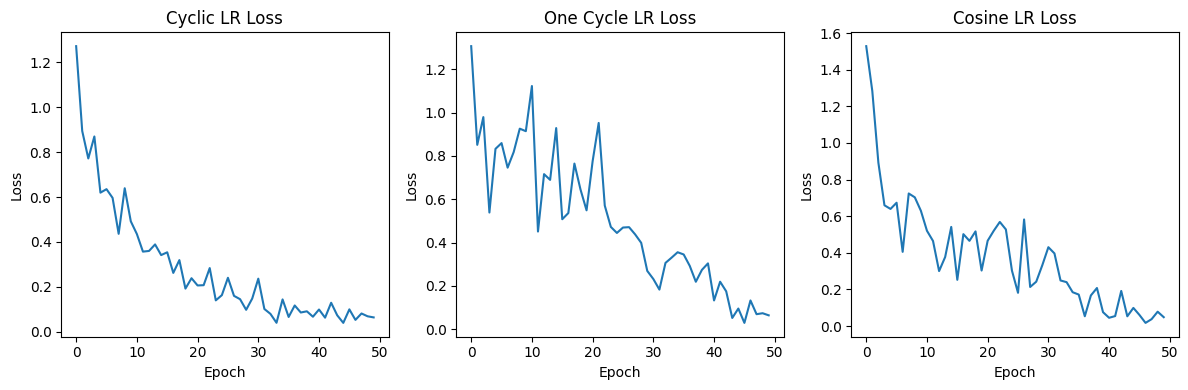

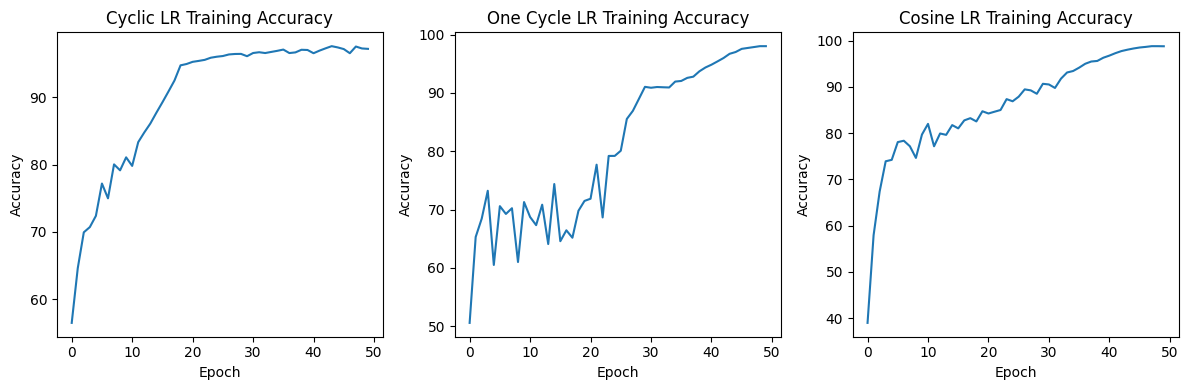

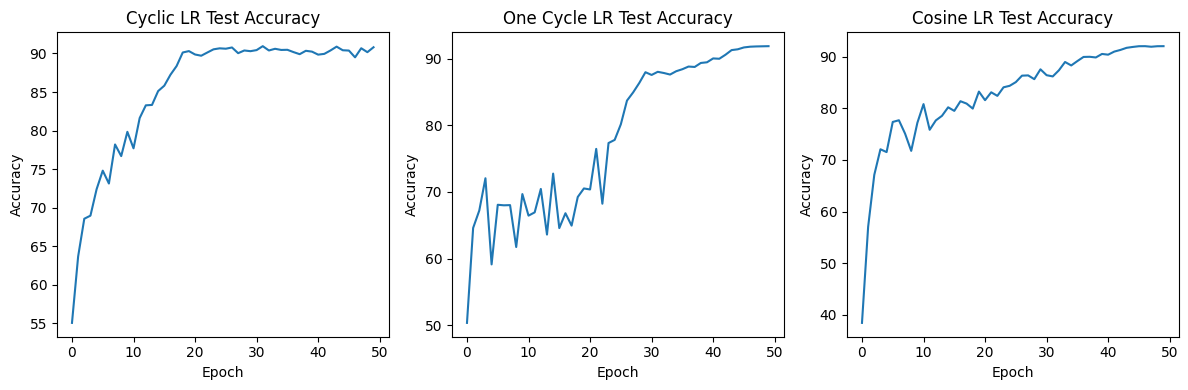

In [5]:
# 绘制 loss 曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(losses_cyclic)
plt.title('Cyclic LR Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(losses_onecycle)
plt.title('One Cycle LR Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(losses_cos)
plt.title('Cosine LR Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('losses.png')

# 绘制训练集准确率曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_acces_cyclic)
plt.title('Cyclic LR Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(train_acces_onecycle)
plt.title('One Cycle LR Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(train_acces_cos)
plt.title('Cosine LR Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('train_accuracy.png')

# 绘制测试集准确率曲线
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(test_acces_cyclic)
plt.title('Cyclic LR Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(test_acces_onecycle)
plt.title('One Cycle LR Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(test_acces_cos)
plt.title('Cosine LR Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('test_accuracy.png')